In [174]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [175]:
class Loan:

    @staticmethod
    def get_recurring_payment_c(*, n, p, r):
        return p * (r * (1 + r)**n) / ((1 + r)**n - 1)
    
    @staticmethod
    def get_current_rate_r(*, k, r, Rs: pd.DataFrame | None, month):
        if Rs is not None:
            rel_Rs = Rs[month >= Rs['month']]['rate']
            if len(rel_Rs) > 0:
                R = rel_Rs.iloc[-1]
                r = R / k
        return r
    
    @staticmethod
    def get_accumulated_offset_o(*, Os: pd.DataFrame | None, month):
        o = 0
        if Os is not None:
            rel_Os = Os[month >= Os['month']]['amount']
            if len(rel_Os) > 0:
                o = rel_Os.sum()
        return o

    def __init__(self, *, N, k, P, R0):
        self.N = N
        self.k = k
        self.P = P
        self.R0 = R0
        
        self.n = self.N * self.k
        self.r0 = self.R0 / self.k
        self.c0 = self.get_recurring_payment_c(n=self.n, p=self.P, r=self.r0)
        self.m0 = self.c0 * self.k / 12
    
    def print(self):
        print('--- Configuration ---')
        print('Term length N:', self.N, 'yrs')
        print('Payments per year k:', self.k)
        print('Principal P:', self.P)
        print('Initial interest R0:', self.R0 * 100, '% pa')
        print('')
        print('--- Analysis ---')
        print('Initial payment per month m0:', f'{self.m0:.2f}')
        print('Initial total amount to be paid:', f'{(self.n * self.c0):.2f}')
        print('Initial total interest to be paid: ', f'{(self.n * self.c0 - self.P):.2f}', f'({((self.n * self.c0 - self.P) / (self.n * self.c0) * 100):.2f}', '%)')
        print('')

    def simulate(self, *,  Rs=None, Os=None):
        plan = []

        p = self.P
        r = self.r0
        o = 0
        e = 0
        i = 0
        while p > o + e:
            i += 1

            prev_month = (i - 1) * 12 / self.k
            curr_month = (i + 0) * 12 / self.k
            curr_year  = (i + 0) / self.k

            r = self.get_current_rate_r(r=r, k=self.k, Rs=Rs, month=prev_month)
            c = self.get_recurring_payment_c(n=self.n - i, p=p, r=r)

            prev_o = self.get_accumulated_offset_o(Os=Os, month=prev_month)
            o = self.get_accumulated_offset_o(Os=Os, month=curr_month)
            o_pay = o - prev_o

            total_pay = c

            interest_pay_planned = p * r
            principal_pay = total_pay - interest_pay_planned
            
            interest_pay = (p - (o + e)) * r
            extra_pay = interest_pay_planned - interest_pay

            p -= principal_pay
            e += extra_pay

            plan.append((i, curr_month, curr_year, r * self.k, o_pay, interest_pay, principal_pay, extra_pay, p, o, e))
        
        plan = pd.DataFrame(plan, columns=['i', 'month', 'year', 'rate', 'offset_pay', 'interest_pay', 'principal_pay', 'extra_pay', 'principal', 'offset', 'extra'])
        plan.set_index('i', drop=False, inplace=True)

        print('--- Simulation ---')
        display(plan.head(5))
        display(plan.tail(5))

        return plan

In [176]:
P = 1100000
N = 20
k = 12
R0 = 0.065

Rs = []
#Rs.append((24, 0.085))
#Rs.append((48, 0.065))
Rs = pd.DataFrame(Rs, columns=['month', 'rate'])
Rs.set_index('month', drop=False, inplace=True)

Os = []
Os.append((0, 100000))
Os = pd.DataFrame(Os, columns=['month', 'amount'])
Os.set_index('month', drop=False, inplace=True)

In [177]:
myLoan1 = Loan(N=N, k=k, P=P, R0=R0)
myLoan1.print()
plan1 = myLoan1.simulate()

--- Configuration ---
Term length N: 20 yrs
Payments per year k: 12
Principal P: 1100000
Initial interest R0: 6.5 % pa

--- Analysis ---
Initial payment per month m0: 8201.30
Initial total amount to be paid: 1968313.08
Initial total interest to be paid:  868313.08 (44.11 %)

--- Simulation ---


,i,month,year,rate,offset_pay,interest_pay,principal_pay,extra_pay,principal,offset,extra
i,,,,,,,,,,,
1,1,1.0,0.083333,0.065,0,5958.333333,2259.728317,0.0,1.097740e+06,0,0.0
2,2,2.0,0.166667,0.065,0,5946.093138,2271.968512,0.0,1.095468e+06,0,0.0
3,3,3.0,0.250000,0.065,0,5933.786642,2284.275008,0.0,1.093184e+06,0,0.0
4,4,4.0,0.333333,0.065,0,5921.413486,2296.648164,0.0,1.090887e+06,0,0.0
5,5,5.0,0.416667,0.065,0,5908.973308,2309.088342,0.0,1.088578e+06,0,0.0


,i,month,year,rate,offset_pay,interest_pay,principal_pay,extra_pay,principal,offset,extra
i,,,,,,,,,,,
235,235,235.0,19.583333,0.065,0,219.000922,7999.060728,0.0,3.243188e+04,0,0.0
236,236,236.0,19.666667,0.065,0,175.672676,8042.388974,0.0,2.438949e+04,0,0.0
237,237,237.0,19.750000,0.065,0,132.109736,8085.951914,0.0,1.630354e+04,0,0.0
238,238,238.0,19.833333,0.065,0,88.310830,8129.750820,0.0,8.173787e+03,0,0.0
239,239,239.0,19.916667,0.065,0,44.274679,8173.786971,0.0,-6.275513e-11,0,0.0


In [178]:
myLoan2 = Loan(N=N, k=k, P=P, R0=R0)
myLoan2.print()
plan2 = myLoan2.simulate(Rs=Rs, Os=Os)

--- Configuration ---
Term length N: 20 yrs
Payments per year k: 12
Principal P: 1100000
Initial interest R0: 6.5 % pa

--- Analysis ---
Initial payment per month m0: 8201.30
Initial total amount to be paid: 1968313.08
Initial total interest to be paid:  868313.08 (44.11 %)

--- Simulation ---


,i,month,year,rate,offset_pay,interest_pay,principal_pay,extra_pay,principal,offset,extra
i,,,,,,,,,,,
1,1,1.0,0.083333,0.065,0,5416.666667,2259.728317,541.666667,1.097740e+06,100000,541.666667
2,2,2.0,0.166667,0.065,0,5401.492444,2271.968512,544.600694,1.095468e+06,100000,1086.267361
3,3,3.0,0.250000,0.065,0,5386.236027,2284.275008,547.550615,1.093184e+06,100000,1633.817976
4,4,4.0,0.333333,0.065,0,5370.896972,2296.648164,550.516514,1.090887e+06,100000,2184.334490
5,5,5.0,0.416667,0.065,0,5355.474830,2309.088342,553.498478,1.088578e+06,100000,2737.832969


,i,month,year,rate,offset_pay,interest_pay,principal_pay,extra_pay,principal,offset,extra
i,,,,,,,,,,,
196,196,196.0,16.333333,0.065,0,185.390550,6479.505551,1553.165550,314484.697404,100000,188291.420892
197,197,197.0,16.416667,0.065,0,141.880248,6514.602872,1561.578530,307970.094531,100000,189852.999422
198,198,198.0,16.500000,0.065,0,98.134265,6549.890305,1570.037080,301420.204227,100000,191423.036502
199,199,199.0,16.583333,0.065,0,54.151325,6585.368877,1578.541448,294834.835350,100000,193001.577950
200,200,200.0,16.666667,0.065,0,9.930144,6621.039625,1587.091881,288213.795724,100000,194588.669831


In [179]:
def plot(ax1, plan: pd.DataFrame):
    ax2 = ax1.twinx()
    # axis 1

    ax1.plot(plan['year'], plan['principal'], 'k-', label='principal')
    ax1.plot(plan['year'], plan['offset'], 'm-', label='offset')
    ax1.plot(plan['year'], plan['offset'] + plan['extra'], 'c-', label='offset + extra')

    principal_half = plan.loc[plan['principal'] <= 0.5 * plan['principal'].iloc[0]].iloc[0]
    ax1.axhline(y=principal_half['principal'], color='y', linestyle='-')
    ax1.axvline(x=principal_half['year'], color='y', linestyle='-')

    ax1.set_xlabel('Years')
    ax1.set_ylabel('Remaining')
    ax1.legend(loc='lower left')

    # axis 2

    ax2.plot(plan['year'], plan['interest_pay'], 'r--', label='interest')
    ax2.plot(plan['year'], plan['principal_pay'], 'g--', label='principal')
    ax2.plot(plan['year'], plan['interest_pay'] + plan['principal_pay'] + plan['extra_pay'], 'b--', label='interest + principal + exta')

    interest_principal_turnover = plan.loc[plan['principal_pay'] >= plan['interest_pay']].iloc[0]
    ax2.axhline(y=interest_principal_turnover['principal_pay'], color='y', linestyle='--')
    ax2.axvline(x=interest_principal_turnover['year'], color='y', linestyle='--')

    ax2.set_ylabel('Payments')
    ax2.legend(loc='center right')

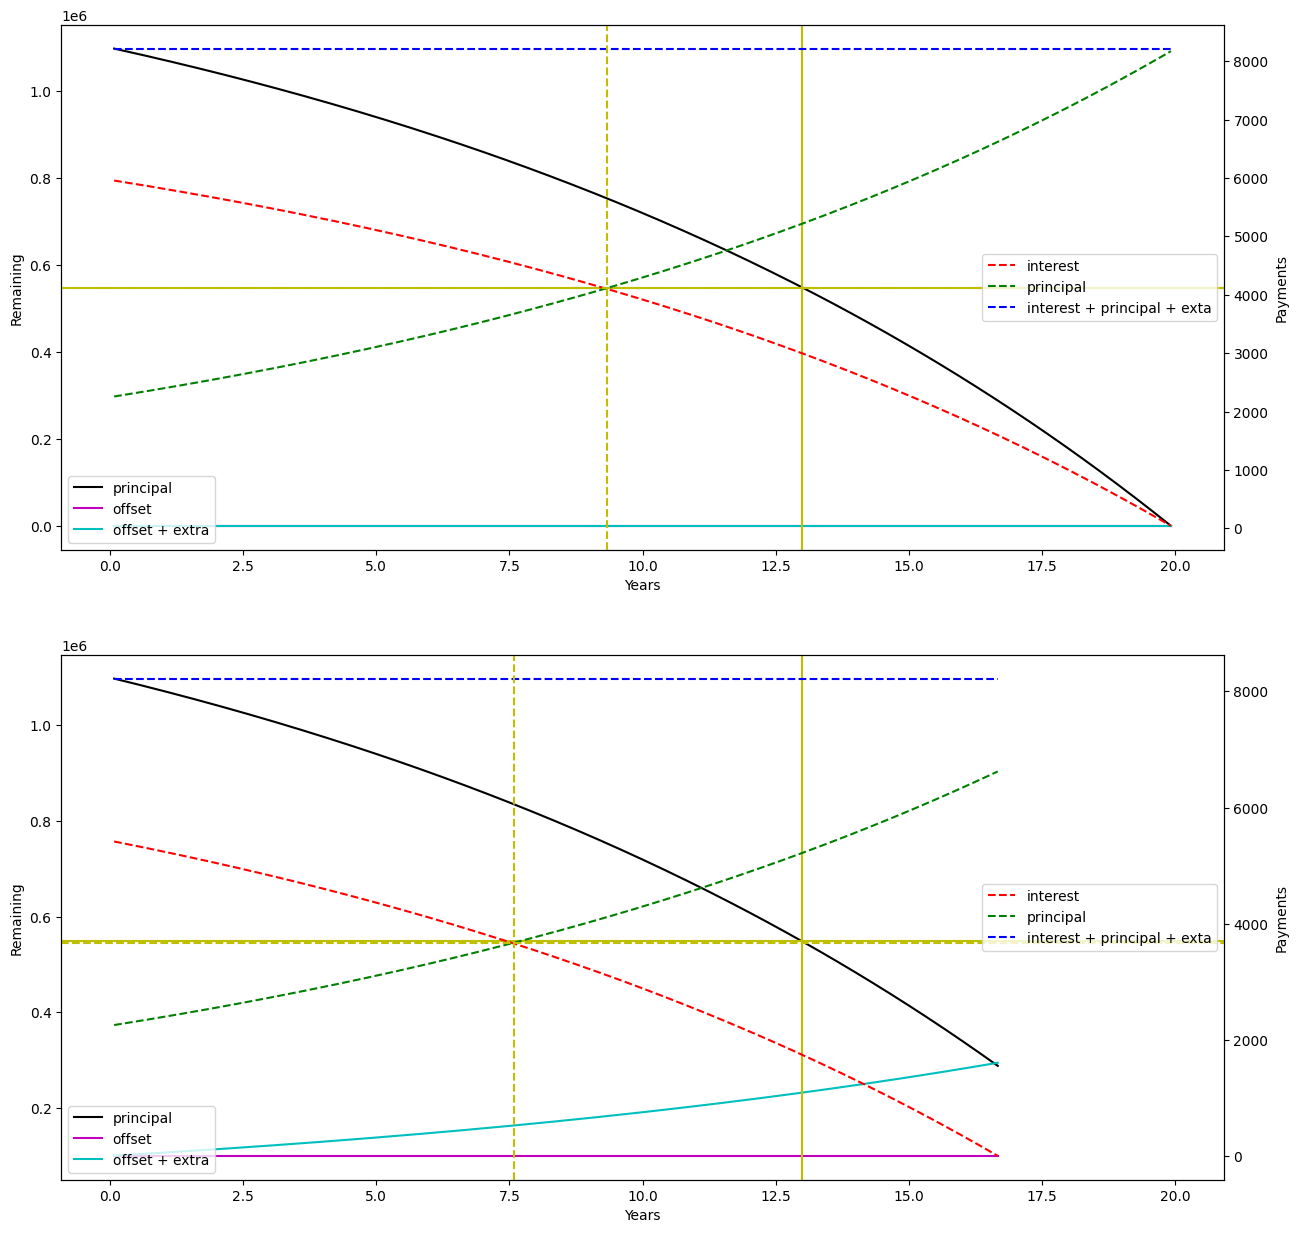

In [180]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))

plot(axs[0], plan1)
plot(axs[1], plan2)

axs[1].set_xlim(axs[0].get_xlim())

plt.show()